In [1]:
from typing import List,TypedDict
import re

import pypdf
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS

from langchain_google_genai import ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import StateGraph, START,END
from pydantic import BaseModel
from dotenv import load_dotenv
load_dotenv()

e:\Machine Learning and Data Science\Advanced-RAGS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [5]:
docs = (
    PyPDFLoader("../documents/oops.pdf").load()
)

### Chunking 

In [8]:
chunk = RecursiveCharacterTextSplitter(chunk_size=800,chunk_overlap=100).split_documents(docs)

for d in chunk:
    d.page_content = d.page_content.encode('utf-8','ignore').decode('utf-8','ignore')

In [9]:
len(chunk)

45

### Embeddings

In [10]:
embeddings = GoogleGenerativeAIEmbeddings(model="gemini-embedding-001")
vector_store = FAISS.from_documents(chunk,embeddings)

### Retriever

In [11]:
retriever = vector_store.as_retriever(search_type="similarity",search_kwargs={"k":2})

### LLM 

In [12]:
llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash-lite')

### Threshold

In [26]:
UPPER_TH = 0.7
LOWER_TH = 0.3

### State

In [38]:
class State(TypedDict):

    question: str
    docs : List[str]

    good_docs : List[str]
    verdict : str
    reason : str

    strips: List[str]
    kept_strips : List[str]
    refined_context : str

    answer : str

### Retrieve Node

In [39]:
def retrieve_node(state: State):
    q = state['question']
    return {'docs': retriever.invoke(q)}

## Score Based Doc Evaluator

In [40]:
class DocEvalScore(BaseModel):
    score: float
    reason: str

doc_eval_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You evaluate RAG retrieval.\n"
            "Given a question and ONE chunk, return relevance score [0–1].\n"
            "1 = sufficient to answer, 0 = irrelevant.\n"
            "Be conservative.\n"
            "Return JSON:"
            ),
        ("human", "Question: {question}\n\nChunk:\n{chunk}")
    ]
)

doc_eval_chain = doc_eval_prompt | llm.with_structured_output(DocEvalScore)

def eval_each_doc_node(state: State):

    q = state['question']

    scores : List[float] = []
    reasons : List[str] = []
    good : List[Document] = []


    for d in state['docs']:

        out = doc_eval_chain.invoke({"question": q,"chunk": d.page_content})
        scores.append(out.score)
        reasons.append(out.reason)

        if out.score > LOWER_TH:
            good.append(d)


    # Correct Case
    if any(s > UPPER_TH for s in scores):
        return {
            'good_docs': good,
            'verdict': "CORRECT",
            "reason": f"At least one retrieved chunk scored > {UPPER_TH}",
        }
    
    # Incorrect Case
    if len(scores) > 0 and all(s < LOWER_TH for s in scores):
        why = "No chunk was sufficient"

        return {
            'good_docs': [],
            'verdict': "INCORRECT",
            "reason": f"All retrieved chunks scored < {LOWER_TH}. {why}",
        }
    
    # Ambiguous
    why = "Mixed relevance signals"
    return {
        "good_docs": good,
        "verdict": "AMBIGUOUS",
        "reason": f"No chunk scored > {UPPER_TH} , but not all were < {LOWER_TH} . {why}"
    }
            


### Knowledge Refining

In [41]:
def decompose_to_sentences(text: str) -> List[str]:
    text = re.sub(r"\s+", " ", text).strip()
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if len(s.strip()) > 20]

class KeepOrDrop(BaseModel):
    keep: bool

filter_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Decide if a sentence helps answer the question. Return JSON"
        ),
        ("human", "Q:{question}\nS:{sentence}")
    ]
)

filter_node = filter_prompt | llm.with_structured_output(KeepOrDrop)

def refine(state: State):

    q = state['question']

    context = "\n\n".join([d.page_content for d in state['good_docs']]).strip()

    strips = decompose_to_sentences(context)

    kept : List[str] = []

    for s in strips:
        if filter_node.invoke({"question": q,"sentence":s}).keep:
            kept.append(s)

    refined_context = "\n".join(kept).strip()

    return {
        'strips': strips,
        'kept_strips': kept,
        'refined_context': refined_context
    }


### Generate Answer

In [42]:
answer_prompt = ChatPromptTemplate.from_messages(
    [
         (
            "system",
            "You are Helpful ML tutor. Answer only using the provided refined bullets.\n"
            "If the bullets are empty or insufficient say: I don't Know based on the provided book"
        ),
        ("human","Question: {question}\n\nRefined Context \n {refined_context}")
    ]
)

def generate(state: State):

    out = (answer_prompt | llm).invoke({"question": state['question'],"refined_context": state['refined_context']})

    return {'answer':out.content}

In [43]:
def fail_node(state: State):
    return {'answer': f"FAIL: {state['reason']}"}

def ambiguous_node(state: State):
    return {'answer': f"Ambiguous: {state['reason']}"}

def route_after_eval(state: State):

    if state['verdict'] == "CORRECT":
        return "refine"
    elif state['verdict'] == 'INCORRECT':
        return "fail_node"
    
    else:
        return "ambiguous_node"

## Graph Build

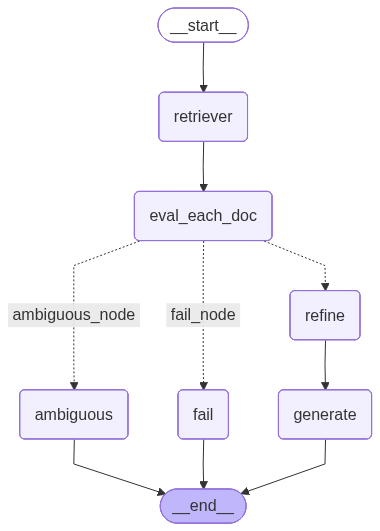

In [44]:
g = StateGraph(State)
g.add_node("retriever",retrieve_node)
g.add_node("eval_each_doc",eval_each_doc_node)
g.add_node("refine",refine)
g.add_node("generate",generate)
g.add_node("fail",fail_node)
g.add_node("ambiguous",ambiguous_node)


g.add_edge(START,'retriever')
g.add_edge("retriever","eval_each_doc")

g.add_conditional_edges(
    "eval_each_doc",
    route_after_eval,
    {"refine":"refine","fail_node":'fail',"ambiguous_node":"ambiguous"}
)

g.add_edge("refine","generate")
g.add_edge("generate",END)
g.add_edge("fail",END)

app = g.compile()
app

In [45]:
res = app.invoke({"question": "What is opps ?"})

In [46]:
print(res['answer'])

OOPs stands for Object-Oriented Programming, which is a programming paradigm based on the concept of objects rather than just functions and procedures.


In [47]:
print(res['verdict'])

CORRECT


In [48]:
print(res['reason'])

At least one retrieved chunk scored > 0.7


In [49]:
res = app.invoke({"question": "What is Large Language model"})

In [50]:
print(res['answer'])

FAIL: All retrieved chunks scored < 0.3. No chunk was sufficient


In [51]:
print(res['verdict'])

INCORRECT


In [52]:
print(res['reason'])

All retrieved chunks scored < 0.3. No chunk was sufficient
